# Modern Portfolio Theory

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import get_data

plt.style.use('seaborn')

# Get stock data

array([[<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>]],
      dtype=object)

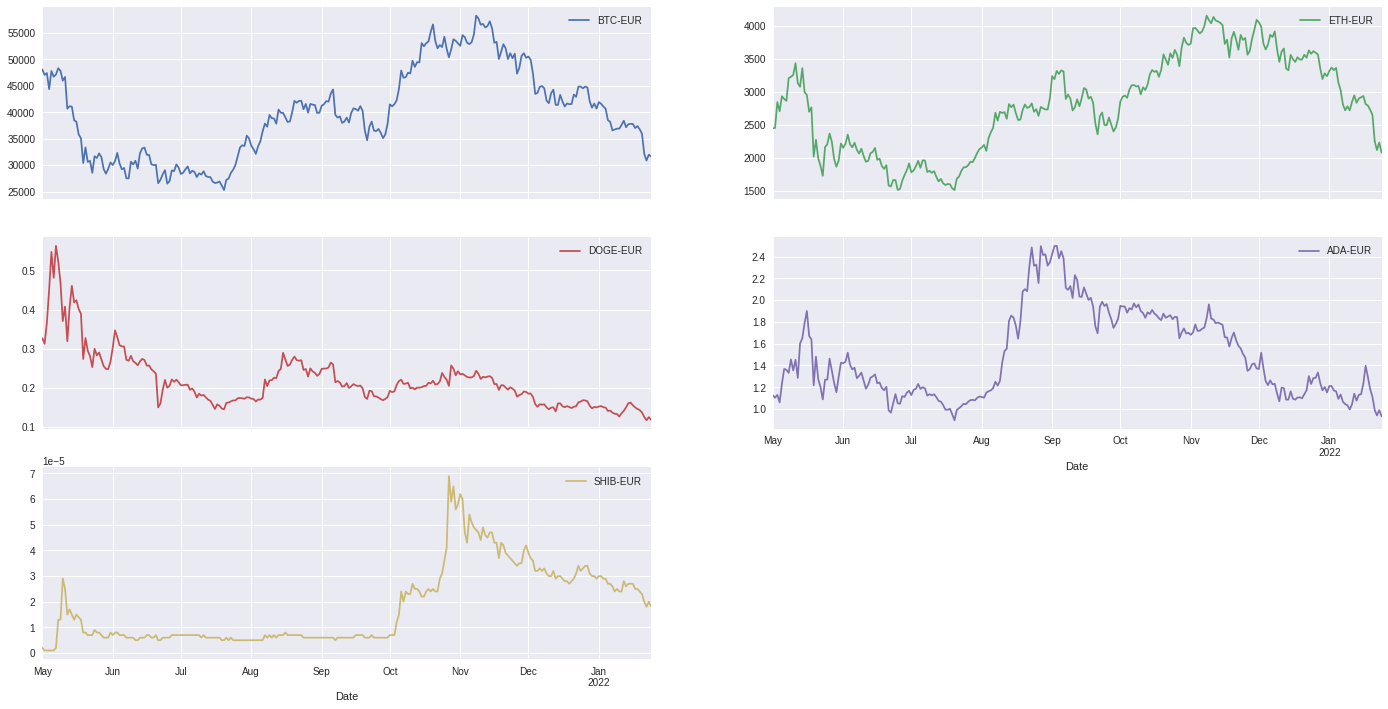

In [2]:
df, stocks = get_data('cryptos')
df = df.loc['2021-05-01':]

df.plot(figsize=(24, 12), subplots=True, layout=(3, 2))

array([[<AxesSubplot:title={'center':'BTC-EUR'}>,
        <AxesSubplot:title={'center':'ETH-EUR'}>],
       [<AxesSubplot:title={'center':'DOGE-EUR'}>,
        <AxesSubplot:title={'center':'ADA-EUR'}>],
       [<AxesSubplot:title={'center':'SHIB-EUR'}>, <AxesSubplot:>]],
      dtype=object)

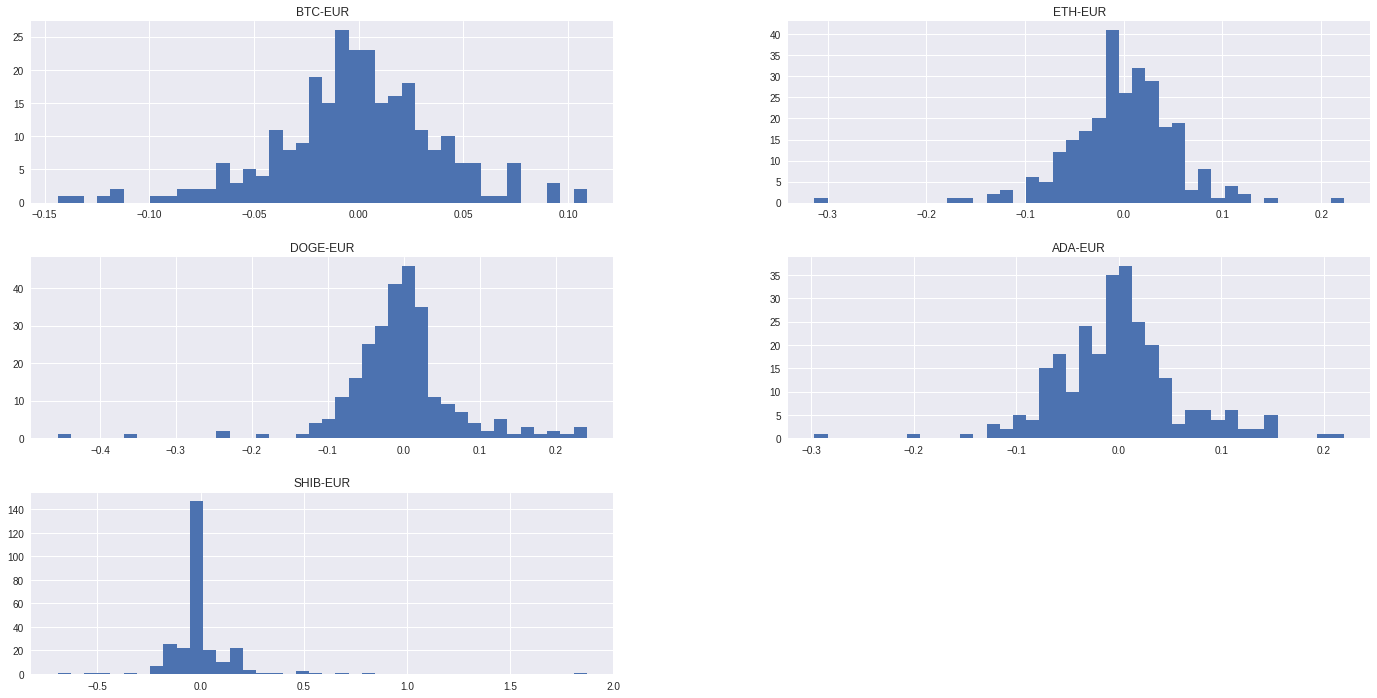

In [3]:
returns = np.log(df / df.shift(1)).dropna()

returns.hist(bins=40, figsize=(24, 12))

In [4]:
returns.mean() * 252

Symbols
BTC-EUR    -0.393385
ETH-EUR    -0.152667
DOGE-EUR   -0.953861
ADA-EUR    -0.175701
SHIB-EUR    2.076384
dtype: float64

In [5]:
returns.cov() * 252

Symbols,BTC-EUR,ETH-EUR,DOGE-EUR,ADA-EUR,SHIB-EUR
Symbols,,,,,
BTC-EUR,0.392208,0.446127,0.498675,0.423581,0.612249
ETH-EUR,0.446127,0.749395,0.692546,0.600827,0.932483
DOGE-EUR,0.498675,0.692546,1.412169,0.743841,0.842832
ADA-EUR,0.423581,0.600827,0.743841,0.949194,0.548609
SHIB-EUR,0.612249,0.932483,0.842832,0.548609,8.073148


In [6]:
# generate random weights
weights = np.random.random(len(stocks))
weights /= np.sum(weights)

# annualized portfolio return
np.sum(returns.mean() * weights) * 252

-0.08803791734078759

In [7]:
# annualized portfolio volatility
np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))

0.7995663271287571

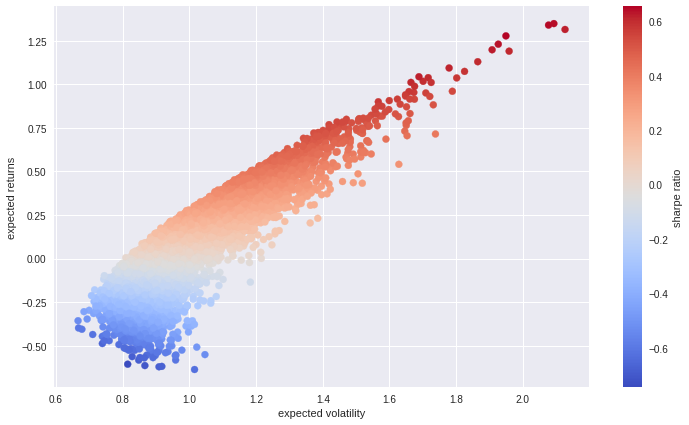

In [8]:
def portfolio_returns(weights):
    return np.sum(returns.mean() * weights) * 252
def portfolio_volatility(weights):
    return np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))

prets = []
pvols = []
for p in range(5000):
    weights = np.random.random(len(stocks))
    weights /= np.sum(weights)
    prets.append(portfolio_returns(weights))
    pvols.append(portfolio_volatility(weights))
    
prets = np.array(prets)
pvols = np.array(pvols)

plt.figure(figsize=(12, 7))
plt.scatter(pvols, prets, c=prets/pvols, marker='o', cmap='coolwarm')
plt.xlabel('expected volatility')
plt.ylabel('expected returns')
plt.colorbar(label='sharpe ratio')

## Find best weights

In [9]:
import scipy.optimize as sco

def min_sharpe(weights):
    return -portfolio_returns(weights) / portfolio_volatility(weights)

cons = ({
    'type': 'eq',
    'fun': lambda x: np.sum(x) - 1
})
bnds = tuple((0, 1) for _ in range(len(stocks)))
eweights = np.array(len(stocks) * [1. / len(weights)])
print(min_sharpe(eweights))

-0.08136803076276504


### Weights with max Sharpe ratio

In [10]:
opts = sco.minimize(
    min_sharpe,
    eweights,
    method='SLSQP',
    bounds=bnds,
    constraints=cons
)
print(stocks)
print('weights', opts['x'].round(3))
print('returns', portfolio_returns(opts['x']).round(5) * 100, '%')
print('volatility', portfolio_volatility(opts['x']))
print('sharpe ratio', portfolio_returns(opts['x']) / portfolio_volatility(opts['x']))

['BTC-EUR', 'ETH-EUR', 'DOGE-EUR', 'ADA-EUR', 'SHIB-EUR']
weights [0. 0. 0. 0. 1.]
returns 207.63799999999998 %
volatility 2.8413284834345274
sharpe ratio 0.7307794048679258


### Weights with minimum volatility

In [11]:
optv = sco.minimize(
    portfolio_volatility,
    eweights,
    method='SLSQP',
    bounds=bnds,
    constraints=cons
)
print(stocks)
print('weights', optv['x'].round(3))
print('returns', portfolio_returns(optv['x']).round(5) * 100, '%')
print('volatility', portfolio_volatility(optv['x']))
print('sharpe ratio', portfolio_returns(optv['x']) / portfolio_volatility(optv['x']))

['BTC-EUR', 'ETH-EUR', 'DOGE-EUR', 'ADA-EUR', 'SHIB-EUR']
weights [1. 0. 0. 0. 0.]
returns -39.339 %
volatility 0.6262653493838154
sharpe ratio -0.6281448613114726


### Efficient frontier

In [18]:
cons = (
    { 'type': 'eq', 'fun': lambda x: portfolio_returns(x) - tret},
    { 'type': 'eq', 'fun': lambda x: np.sum(x) - 1 }
)
bnds = tuple((0, 1) for _ in range(len(stocks)))

target_rets = np.linspace(-0.5, 2.1, 50)
target_vols = []

for tret in target_rets:
    res = sco.minimize(
        portfolio_volatility,
        eweights,
        method='SLSQP',
        bounds=bnds,
        constraints=cons
    )
    target_vols.append(res['fun'])
target_vols = np.array(target_vols)

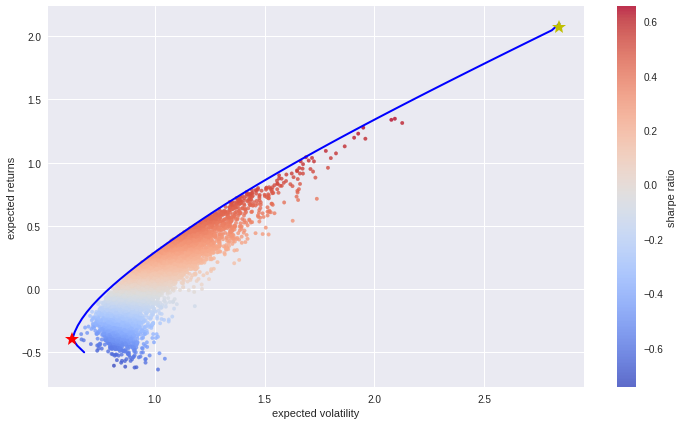

In [19]:
plt.figure(figsize=(12, 7))
plt.scatter(pvols, prets, c=prets/pvols, marker='.', alpha=0.8, cmap='coolwarm')
plt.plot(target_vols, target_rets, 'b', lw=2.0)
plt.plot(portfolio_volatility(opts['x']), portfolio_returns(opts['x']), 'y*', markersize=15.0)
plt.plot(portfolio_volatility(optv['x']), portfolio_returns(optv['x']), 'r*', markersize=15.0)
plt.xlabel('expected volatility')
plt.ylabel('expected returns')
plt.colorbar(label='sharpe ratio')

### Capital market line

In [20]:
import scipy.interpolate as sci

ind = np.argmin(target_vols)
evols = target_vols[ind:]
erets = target_rets[ind:]

tck = sci.splrep(evols, erets)

def f(x):
    """ Efficient frontier function (splines approximation). """
    return sci.splev(x, tck, der=0)
def df(x):
    """ First derivative of efficient frontier function. """
    return sci.splev(x, tck, der=1)
def equations(p, rf=0.01):
    eq1 = rf - p[0]
    eq2 = rf + p[1] * p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3

opt = sco.fsolve(equations, [0.01, 0.5, 0.15])
opt

/home/tossan/Documents/coding/python/finance-research/venv/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


array([0.01      , 0.72493392, 2.75783048])

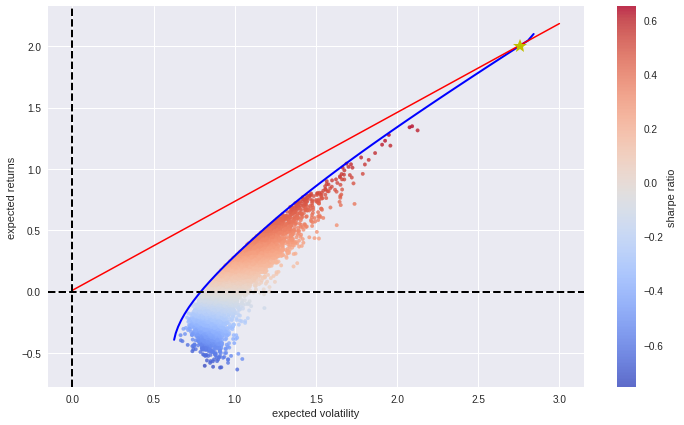

In [23]:
plt.figure(figsize=(12, 7))
plt.scatter(pvols, prets, c=(prets - 0.01) / pvols, marker='.', alpha=0.8, cmap='coolwarm')
plt.plot(evols, erets, 'b', lw=2.0)

cx = np.linspace(0.0, 3.0)
plt.plot(cx, opt[0] + opt[1] * cx, 'r', lw=1.5)
plt.plot(opt[2], f(opt[2]), 'y*', markersize=15.0)
plt.grid(True)
plt.axhline(0, color='k', ls='--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)

plt.xlabel('expected volatility')
plt.ylabel('expected returns')
plt.colorbar(label='sharpe ratio')

In [24]:
cons = (
    { 'type': 'eq', 'fun': lambda x: portfolio_returns(x) - f(opt[2])},
    { 'type': 'eq', 'fun': lambda x: np.sum(x) - 1 }
)
bnds = tuple((0, 1) for _ in range(len(stocks)))


res = sco.minimize(
    portfolio_volatility,
    eweights,
    method='SLSQP',
    bounds=bnds,
    constraints=cons
)

print(stocks)
print('weights', res['x'].round(3))
print('returns', portfolio_returns(res['x']).round(5) * 100, '%')
print('volatility', portfolio_volatility(res['x']))
print('sharpe ratio', portfolio_returns(res['x']) / portfolio_volatility(res['x']))

['BTC-EUR', 'ETH-EUR', 'DOGE-EUR', 'ADA-EUR', 'SHIB-EUR']
weights [0.    0.    0.    0.032 0.968]
returns 200.385 %
volatility 2.7562119134893885
sharpe ratio 0.7270321887069151
